In [ ]:
import os
from google.colab import drive
import sys

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ZooTransform')
sys.path.append(os.path.abspath('/content/drive/MyDrive/ZooTransform/src'))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## load GYM data:
from src.zootransform.dataset.protein_gym_download_and_clean import download_gym_data, get_gym_data
from src.zootransform.validation.visualization import plot_loglikelihood_vs_dmscore
from src.zootransform.utils.utils import DEVICE, compute_sequence_likelihoods
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch


data = get_gym_data()
print(data.head())


model_name = "facebook/esm2_t6_8M_UR50D"

model_pre = AutoModelForMaskedLM.from_pretrained(model_name).to(DEVICE)
tokenizer_pre = AutoTokenizer.from_pretrained(model_name)

Loading CSV files...
['src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/SDA_BACSU_Tsuboyama_2023_1PV0.csv', 'src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/PAI1_HUMAN_Huttinger_2021.csv', 'src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/S22A1_HUMAN_Yee_2023_activity.csv', 'src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/HIS7_YEAST_Pokusaeva_2019.csv', 'src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/AMIE_PSEAE_Wrenbeck_2017.csv', 'src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/ACE2_HUMAN_Chan_2020.csv', 'src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/RDRP_I33A0_Li_2023.csv', 'src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/CASP3_HUMAN_Roychowdhury_2020.csv', 'src/zootransform/dataset/ProteinGym_DMS_data/DMS_ProteinGym_substitutions/RL40A_YEAST_Roscoe_2014.csv', 'src/zootransform/

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
!ls

load_the_model.ipynb	      README.md		Training_data.ipynb
lora_finetuned_species_model  requirements.txt	uniprot_data
optuna.ipynb		      setup.cfg		validations.ipynb
pyproject.toml		      src


In [ ]:
config.base_model_name_or_path

'facebook/esm2_t6_8M_UR50D'

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
from peft import PeftModel, PeftConfig

peft_model_path = "./finetuned20"

tokenizer_tuned = AutoTokenizer.from_pretrained(peft_model_path)

# Load adapter config locally
config = PeftConfig.from_pretrained(peft_model_path)

# Load base model
base_model = AutoModelForMaskedLM.from_pretrained(config.base_model_name_or_path)
base_model.resize_token_embeddings(len(tokenizer_tuned))

old_bias = base_model.lm_head.bias
old_vocab_size = old_bias.size(0)
new_vocab_size = len(tokenizer_tuned)

if old_vocab_size != new_vocab_size:
    print(f"Resizing lm_head.bias: {old_vocab_size} → {new_vocab_size}")
    new_bias = torch.zeros(new_vocab_size, device=old_bias.device, dtype=old_bias.dtype)
    # Copy over the old bias values
    new_bias[:old_vocab_size] = old_bias
    base_model.lm_head.bias = torch.nn.Parameter(new_bias)

# Load LoRA weights locally
model_tuned = PeftModel.from_pretrained(base_model, peft_model_path)



Resizing lm_head.bias: 33 → 45


In [ ]:

sequences = data["mutated_sequence"].tolist()[:10]


_, likelihoods_pre = compute_sequence_likelihoods(sequences=sequences, model=model_pre, tokenizer=tokenizer_pre)
_, likelihhods = compute_sequence_likelihoods(sequences=sequences, model=model_tuned, tokenizer=tokenizer_tuned)

EsmTokenizer(name_or_path='facebook/esm2_t6_8M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


EsmTokenizer(name_or_path='./finetuned20', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>', 'additional_special_tokens': ['<sp_Arabidopsis thaliana>', '<sp_Bos taurus>', '<sp_Escherichia coli>', '<sp_Homo sapiens>', '<sp_Mus musculus>', '<sp_Oryza sativa>', '<sp_Rattus norvegicus>', '<sp_Rhodotorula toruloides>', '<sp_Saccharolobus solfataricus>', '<sp_Saccharomyces cerevisiae>', '<sp_Schizosaccharomyces pombe>', '<sp_Staphylococcus aureus>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normali

100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


/tmp/ipython-input-2236697248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['LogLikelihoodPre'] = likelihoods_pre
/tmp/ipython-input-2236697248.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['LogLikelihood'] = likelihhods
/tmp/ipython-input-2236697248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tm

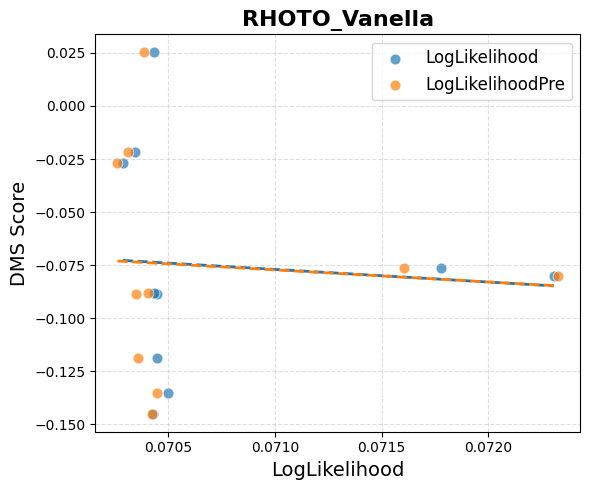

In [ ]:
tmp = data.iloc[:10]

tmp['LogLikelihoodPre'] = likelihoods_pre
tmp['LogLikelihood'] = likelihhods
tmp.rename(columns={'species': 'Species'}, inplace=True)
plot_loglikelihood_vs_dmscore(tmp)